<a href="https://colab.research.google.com/github/kartikgill/TF2-Keras-GAN-Notebooks/blob/main/dcgan/DC-GAN-Fashion-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


In [3]:
# Globals
dim = 50   # dimensions
epochs = 100
batch_size = 100
steps = 5
noise_size = dim

# Download and show Data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


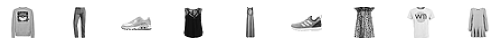

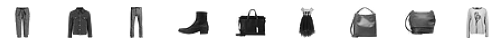

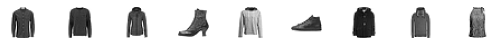

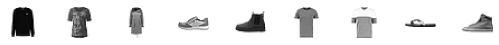

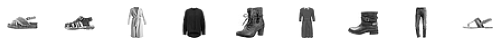

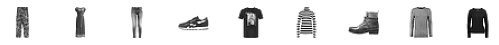

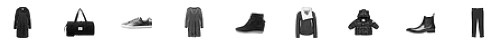

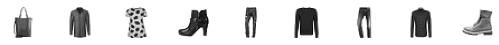

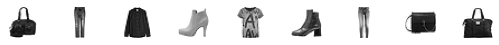

In [4]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# reduce the amount of input data
#trainX = trainX[:50]
#trainY = trainY[:50]

#testX = testX[:20]
#testX = testX[:20]

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Normalize data

In [5]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = dim)

x = tensorflow.keras.layers.Dense(128 * 5 * 5)(random_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 128))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 3200)              163200    
_________________________________________________________________
activation (Activation)      (None, 3200)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3200)              12800     
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 128)         409728    
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 128)        

# Define Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)        

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define combined model : DCGAN

In [9]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

dcgan_model = tensorflow.keras.models.Model(random_input, d_output)
dcgan_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
functional_1 (Functional)    (None, 28, 28, 1)         2200833   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 1223553   
Total params: 3,424,386
Trainable params: 2,193,921
Non-trainable params: 1,230,465
_________________________________________________________________


# Compiling DCGAN

In [10]:
dcgan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [11]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

# Training DCGAN

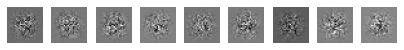

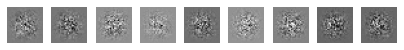

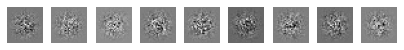

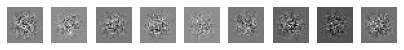

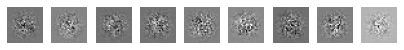

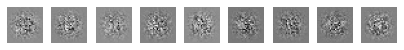

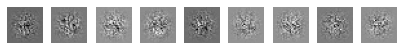

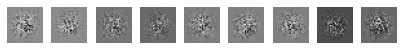

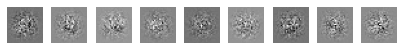

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./content/fashion_model_0\assets
Epoch:0, Step:0, D-Loss:0.574, D-Acc:85.000, G-Loss:0.726
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:1, Step:0, D-Loss:0.017, D-Acc:100.000, G-Loss:1.290
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:2, Step:0, D-Loss:0.016, D-Acc:100.000, G-Loss:1.254
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:3, Step:0, D-Loss:0.072, D-Acc:98.000, G-Loss:3.359
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:4, Step:0, D-Loss:0.169, D-Acc:97.000, G-Loss:4.062
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:5, Step:0, D-Loss:0.038, D-Acc:99.000, G-Loss:4.25

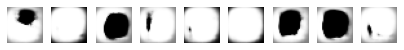

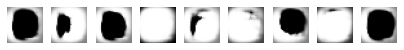

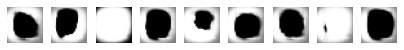

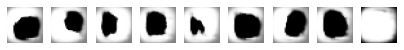

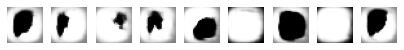

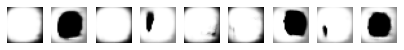

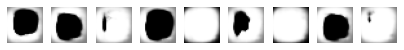

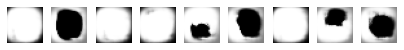

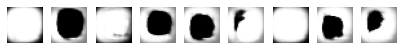

INFO:tensorflow:Assets written to: ./content/fashion_model_10\assets
Epoch:10, Step:0, D-Loss:0.078, D-Acc:98.000, G-Loss:3.769
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:11, Step:0, D-Loss:0.097, D-Acc:97.000, G-Loss:5.864
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:12, Step:0, D-Loss:0.041, D-Acc:100.000, G-Loss:4.977
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:13, Step:0, D-Loss:0.070, D-Acc:98.000, G-Loss:5.201
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:14, Step:0, D-Loss:0.034, D-Acc:100.000, G-Loss:4.870
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:15, Step:0, D-Loss:0.117, D-Acc:98.000, G-Loss:3.121
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:16, Step:0, D-Loss:0.106, D-Acc:95.000, G-Loss:9.069
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:17, Step:0, D-Loss:0

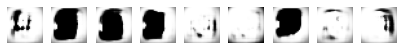

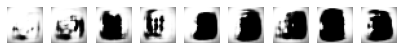

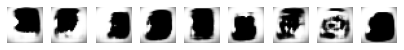

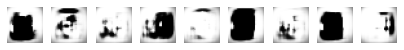

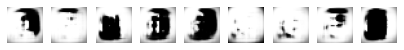

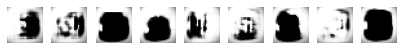

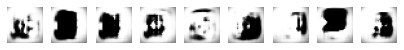

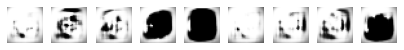

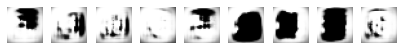

INFO:tensorflow:Assets written to: ./content/fashion_model_20\assets
Epoch:20, Step:0, D-Loss:0.088, D-Acc:97.000, G-Loss:4.307
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:21, Step:0, D-Loss:0.060, D-Acc:99.000, G-Loss:4.063
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:22, Step:0, D-Loss:0.216, D-Acc:91.000, G-Loss:4.807
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:23, Step:0, D-Loss:0.098, D-Acc:98.000, G-Loss:4.227
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:24, Step:0, D-Loss:0.076, D-Acc:99.000, G-Loss:3.698
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:25, Step:0, D-Loss:0.083, D-Acc:98.000, G-Loss:3.711
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:26, Step:0, D-Loss:0.089, D-Acc:98.000, G-Loss:6.965
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:27, Step:0, D-Loss:0.0

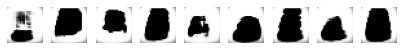

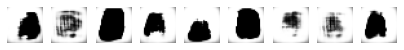

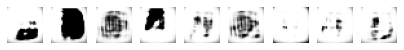

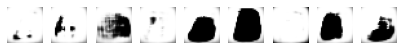

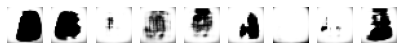

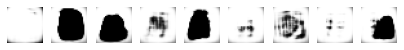

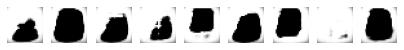

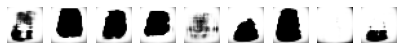

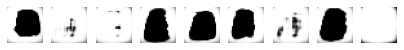

INFO:tensorflow:Assets written to: ./content/fashion_model_30\assets
Epoch:30, Step:0, D-Loss:0.114, D-Acc:96.000, G-Loss:4.475
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:31, Step:0, D-Loss:0.098, D-Acc:97.000, G-Loss:4.235
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:32, Step:0, D-Loss:0.052, D-Acc:100.000, G-Loss:6.419
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:33, Step:0, D-Loss:0.084, D-Acc:98.000, G-Loss:3.659
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:34, Step:0, D-Loss:0.098, D-Acc:98.000, G-Loss:5.057
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:35, Step:0, D-Loss:0.065, D-Acc:98.000, G-Loss:8.690
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:36, Step:0, D-Loss:0.094, D-Acc:96.000, G-Loss:3.516
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:37, Step:0, D-Loss:0.

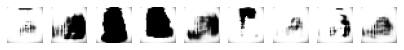

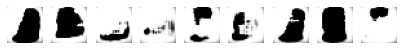

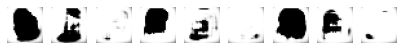

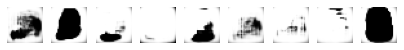

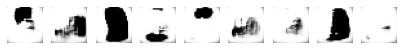

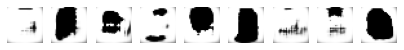

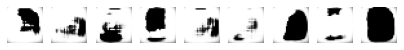

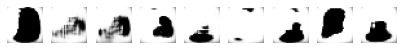

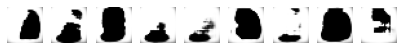

INFO:tensorflow:Assets written to: ./content/fashion_model_40\assets
Epoch:40, Step:0, D-Loss:0.086, D-Acc:97.000, G-Loss:3.776
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:41, Step:0, D-Loss:0.191, D-Acc:91.000, G-Loss:6.499
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:42, Step:0, D-Loss:0.113, D-Acc:95.000, G-Loss:5.234
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:43, Step:0, D-Loss:0.059, D-Acc:98.000, G-Loss:4.339
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:44, Step:0, D-Loss:0.075, D-Acc:99.000, G-Loss:4.114
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:45, Step:0, D-Loss:0.107, D-Acc:97.000, G-Loss:6.779
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:46, Step:0, D-Loss:0.083, D-Acc:98.000, G-Loss:8.377
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:47, Step:0, D-Loss:0.0

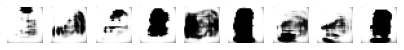

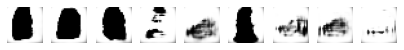

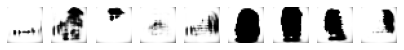

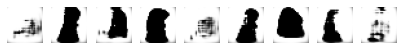

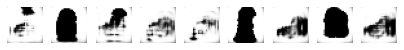

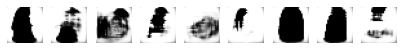

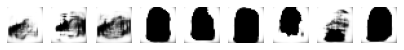

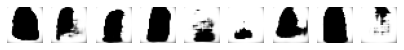

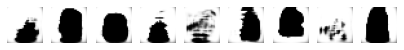

INFO:tensorflow:Assets written to: ./content/fashion_model_50\assets
Epoch:50, Step:0, D-Loss:0.108, D-Acc:98.000, G-Loss:2.879
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:51, Step:0, D-Loss:0.061, D-Acc:98.000, G-Loss:2.073
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:52, Step:0, D-Loss:0.156, D-Acc:94.000, G-Loss:1.658
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:53, Step:0, D-Loss:0.051, D-Acc:100.000, G-Loss:5.865
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:54, Step:0, D-Loss:0.115, D-Acc:97.000, G-Loss:7.628
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:55, Step:0, D-Loss:0.084, D-Acc:99.000, G-Loss:4.232
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:56, Step:0, D-Loss:0.191, D-Acc:91.000, G-Loss:4.437
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:57, Step:0, D-Loss:0.

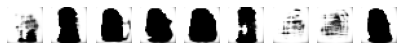

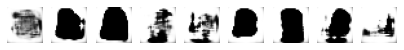

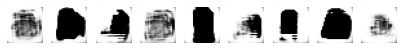

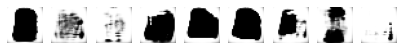

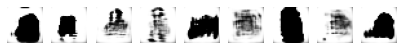

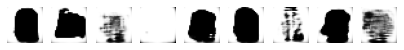

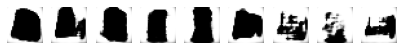

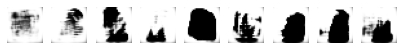

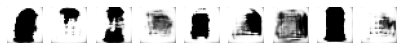

INFO:tensorflow:Assets written to: ./content/fashion_model_60\assets
Epoch:60, Step:0, D-Loss:0.045, D-Acc:99.000, G-Loss:2.109
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:61, Step:0, D-Loss:0.044, D-Acc:100.000, G-Loss:2.798
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:62, Step:0, D-Loss:0.141, D-Acc:94.000, G-Loss:3.208
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:63, Step:0, D-Loss:0.082, D-Acc:98.000, G-Loss:5.669
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:64, Step:0, D-Loss:0.101, D-Acc:98.000, G-Loss:6.237
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:65, Step:0, D-Loss:0.158, D-Acc:95.000, G-Loss:3.780
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:66, Step:0, D-Loss:0.142, D-Acc:96.000, G-Loss:5.925
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:67, Step:0, D-Loss:0.

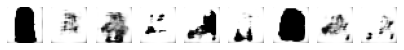

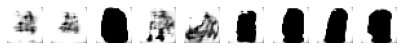

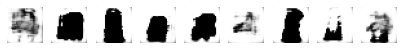

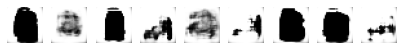

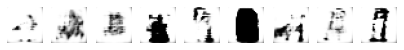

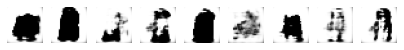

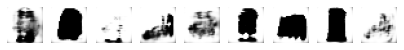

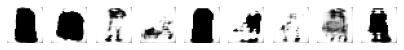

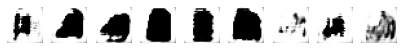

INFO:tensorflow:Assets written to: ./content/fashion_model_70\assets
Epoch:70, Step:0, D-Loss:0.137, D-Acc:92.000, G-Loss:4.181
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:71, Step:0, D-Loss:0.087, D-Acc:98.000, G-Loss:5.711
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:72, Step:0, D-Loss:0.114, D-Acc:97.000, G-Loss:3.509
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:73, Step:0, D-Loss:0.076, D-Acc:98.000, G-Loss:4.530
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:74, Step:0, D-Loss:0.110, D-Acc:94.000, G-Loss:2.137
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:75, Step:0, D-Loss:0.074, D-Acc:97.000, G-Loss:4.264
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:76, Step:0, D-Loss:0.138, D-Acc:96.000, G-Loss:8.995
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:77, Step:0, D-Loss:0.1

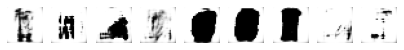

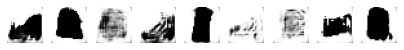

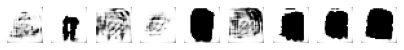

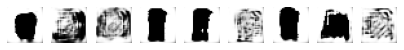

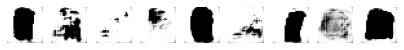

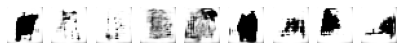

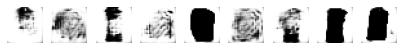

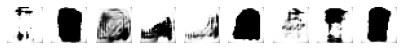

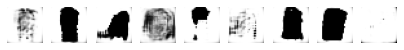

INFO:tensorflow:Assets written to: ./content/fashion_model_80\assets
Epoch:80, Step:0, D-Loss:0.067, D-Acc:99.000, G-Loss:12.906
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:81, Step:0, D-Loss:0.124, D-Acc:95.000, G-Loss:4.368
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:82, Step:0, D-Loss:0.074, D-Acc:99.000, G-Loss:2.410
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:83, Step:0, D-Loss:0.060, D-Acc:99.000, G-Loss:3.653
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:84, Step:0, D-Loss:0.069, D-Acc:98.000, G-Loss:4.975
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:85, Step:0, D-Loss:0.079, D-Acc:98.000, G-Loss:4.717
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:86, Step:0, D-Loss:0.117, D-Acc:96.000, G-Loss:2.891
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:87, Step:0, D-Loss:0.

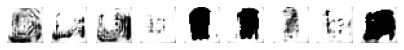

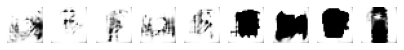

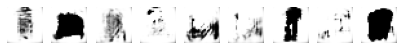

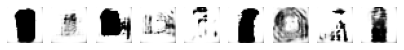

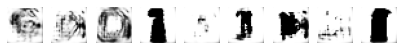

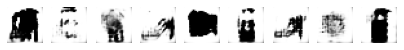

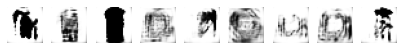

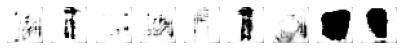

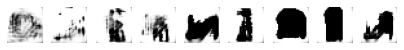

INFO:tensorflow:Assets written to: ./content/fashion_model_90\assets
Epoch:90, Step:0, D-Loss:0.064, D-Acc:98.000, G-Loss:4.529
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:91, Step:0, D-Loss:0.100, D-Acc:96.000, G-Loss:7.347
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:92, Step:0, D-Loss:0.147, D-Acc:97.000, G-Loss:7.884
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:93, Step:0, D-Loss:0.104, D-Acc:96.000, G-Loss:3.295
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:94, Step:0, D-Loss:0.076, D-Acc:99.000, G-Loss:8.757
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:95, Step:0, D-Loss:0.107, D-Acc:98.000, G-Loss:3.149
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:96, Step:0, D-Loss:0.126, D-Acc:97.000, G-Loss:3.153
INFO:tensorflow:Assets written to: ./content/fashion_model_new\assets
Epoch:97, Step:0, D-Loss:0.0

In [12]:
#epochs = 5
#batch_size = 10
#steps = 5
#noise_size = 100

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
        generator_network.save('./content/fashion_model_'+ str(i))
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = dcgan_model.train_on_batch(gan_input, gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
    generator_network.save('./content/fashion_model_new')
            

# Results

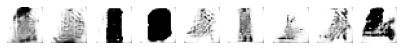

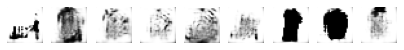

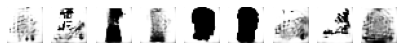

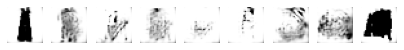

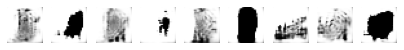

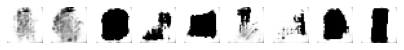

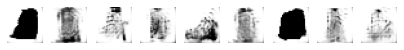

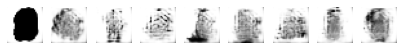

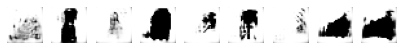

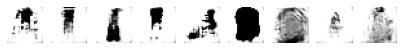

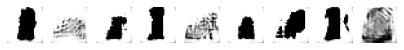

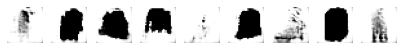

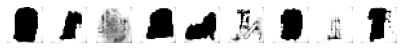

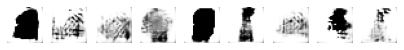

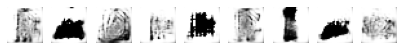

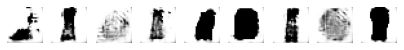

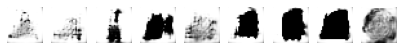

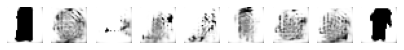

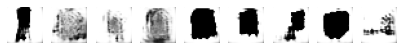

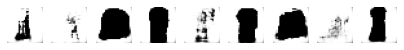

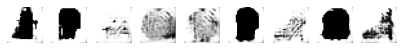

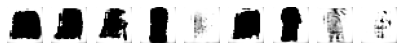

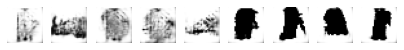

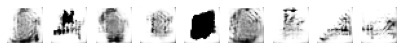

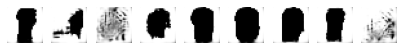

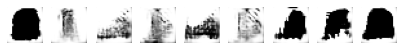

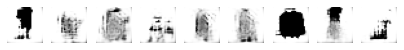

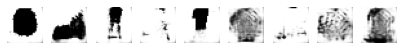

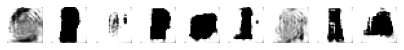

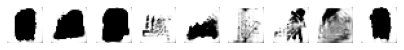

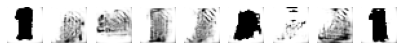

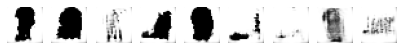

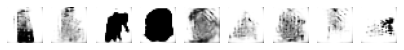

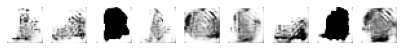

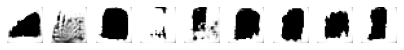

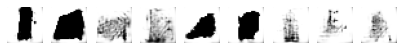

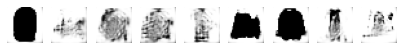

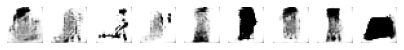

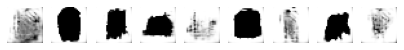

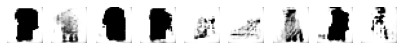

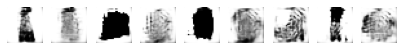

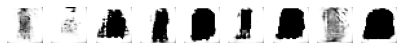

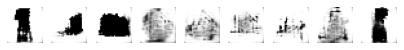

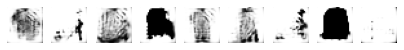

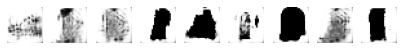

In [13]:
#Generating Unlimited samples
noise_size=dim
generator_network = tensorflow.keras.models.load_model('./content/fashion_model_new')
for i in range(5):
    show_generator_results(generator_network)